In [146]:
from google.colab import files
uploaded = files.upload()

Saving training_SC_GGP_AXA_FR.csv to training_SC_GGP_AXA_FR (1).csv


In [289]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import datetime as dt
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree

In [290]:
df = pd.read_csv('training_SC_GGP_AXA_FR.csv',sep=',')
df.head(10)

,index,age,departement,categorie_socio_professionnelle,type_de_bien,statut,surface,montant_assure,debut_contrat,nb_sinistres_depuis_ouverture,ouverture_dernier_sinistre,cloture_dernier_sinistre,cotisation_n-1,cotisation_n,target
0,0,46.0,92,"Artisans, commerçants, chefs d'entreprise",Appartement,Occupant à titre gratuit,65.30,15074.0,1996-02-04 00:00:00,2.0,1999-06-23 18:33:38,1999-08-16 18:33:38,222.22,235.18,0
1,1,30.0,93,Employés,Appartement,Propriétaire,61.96,29868.0,1997-12-15 00:00:00,1.0,1999-03-29 18:54:35,1999-04-28 18:54:35,191.55,193.06,0
2,2,26.0,70,"Artisans, commerçants, chefs d'entreprise",Maison,Locataire,121.87,23310.0,2007-12-03 00:00:00,2.0,2008-09-10 11:50:29,2009-01-21 11:50:29,376.53,376.53,0
3,3,37.0,86,Employés,Maison,Propriétaire,73.85,16432.0,2014-02-16 00:00:00,1.0,2017-07-31 13:42:48,2017-09-25 13:42:48,364.31,394.98,1
4,4,29.0,18,Cadres et professions intellectuelles supérieures,Appartement,Locataire,64.34,15943.0,1995-02-17 00:00:00,2.0,1998-07-27 12:39:12,1998-10-28 12:39:12,232.28,245.56,0
5,5,22.0,08,Cadres et professions intellectuelles supérieures,Maison,Locataire,96.20,18678.0,2012-11-08 00:00:00,1.0,2016-12-25 07:49:07,2017-02-08 07:49:07,360.96,366.66,0
6,6,15.0,78,Cadres et professions intellectuelles supérieures,Appartement,Occupant à titre gratuit,57.73,28578.0,2004-10-11 00:00:00,1.0,2009-08-23 15:59:50,2009-12-19 15:59:50,245.56,246.03,0
7,7,31.0,77,Employés,Maison,Propriétaire,87.58,32808.0,2000-02-26 00:00:00,2.0,2003-02-27 04:37:48,2003-04-17 04:37:48,369.11,385.15,1
8,8,36.0,85,Employés,Maison,Locataire,104.94,16700.0,2004-01-08 00:00:00,1.0,2008-03-08 18:30:54,2008-04-15 18:30:54,405.67,454.90,0
9,9,55.0,67,Agriculteurs exploitants,Appartement,Propriétaire,76.59,22078.0,2019-08-27 00:00:00,2.0,2020-12-11 14:01:01,2020-12-22 14:01:01,223.86,237.23,0


Il y a 1000 observations et 15 features dans ce dataset. 



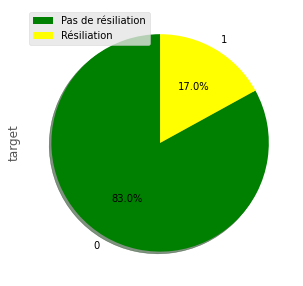

In [291]:
print("Il y a {} observations et {} features dans ce dataset. \n".format(df.shape[0],df.shape[1]))
#on définit les labels et les couleurs du graphe
colors = ['green', 'yellow']
labels = ['Pas de résiliation', 'Résiliation']
#on plot le graphe en ne gardant que la colonne target
df["target"].value_counts(normalize=False).plot(kind='pie', figsize=(5, 5), colors=colors,autopct='%1.1f%%', shadow=True, startangle=90) 
#on ajoute une légende
plt.legend(labels,loc='best')
plt.show()

La fonction categorize ci-dessous va nous permettre d'encoder les données catégoriques afin de les rendre lisibles par le modèle de machine learning.

je supprime également la colonne index car l'index n'est pas une donnée issue de l'information client mais une donnée que nous avons rajouté nous. Il se peut que la colonne index fausse notre analyse si on la laisse. Il ne faut pas que le modèle de machine learning créé des règles sur l'index

In [292]:
def categorize(df):
  #on convertit les colonnes correspondants à des variables catégoriques en type category
  df['type_de_bien'] = df['type_de_bien'].astype('category')
  df['statut'] = df['statut'].astype('category')
  df['categorie_socio_professionnelle'] = df['categorie_socio_professionnelle'].astype('category')
  df['departement'] = df['departement'].astype('category')

  #on fait un cat.codes qui est une fonctionnalité de pandas pour prévenir la présence de données manquantes
  df['type_de_bien'] = df['type_de_bien'].cat.codes
  df['statut'] = df['statut'].cat.codes
  df['categorie_socio_professionnelle'] = df['categorie_socio_professionnelle'].cat.codes
  df['departement'] = df['departement'].cat.codes

  #on drop la colonne index car elle n'a pas de sens assurantiel
  df = df.drop(columns=['index'])
  return df.head()

In [293]:
categorize(df)

,age,departement,categorie_socio_professionnelle,type_de_bien,statut,surface,montant_assure,debut_contrat,nb_sinistres_depuis_ouverture,ouverture_dernier_sinistre,cloture_dernier_sinistre,cotisation_n-1,cotisation_n,target
0,46.0,92,1,0,1,65.30,15074.0,1996-02-04 00:00:00,2.0,1999-06-23 18:33:38,1999-08-16 18:33:38,222.22,235.18,0
1,30.0,93,3,0,2,61.96,29868.0,1997-12-15 00:00:00,1.0,1999-03-29 18:54:35,1999-04-28 18:54:35,191.55,193.06,0
2,26.0,70,1,1,0,121.87,23310.0,2007-12-03 00:00:00,2.0,2008-09-10 11:50:29,2009-01-21 11:50:29,376.53,376.53,0
3,37.0,86,3,1,2,73.85,16432.0,2014-02-16 00:00:00,1.0,2017-07-31 13:42:48,2017-09-25 13:42:48,364.31,394.98,1
4,29.0,17,2,0,0,64.34,15943.0,1995-02-17 00:00:00,2.0,1998-07-27 12:39:12,1998-10-28 12:39:12,232.28,245.56,0


Maintenant que les données catégoriques ont été encodées, il s'agit de s'attaquer aux dates. En effet, dans notre situation on ne peut pas garder le format date afin de faire fonctionner notre modèle. J'ai donc séparé chaque date en 4 colonnes qui sont respectivement année, mois, jour et heure.

Ici on a un enjeu qui est la gestion des données manquantes. Il faut prévoir le fait que certaines cellules sont vides et que lorsque ces cellules sont vides, cela a un sens.

Le choix ici pour la gestion des données manquantes a été de mettre (-1) en valeur, ainsi quand il y a (-1), cela veut dire qu'il n'y jamais eu de sinistre pour ce contrat.

le choix a aussi été fait ici de ne pas prendre en compte les minutes et les secondes pour le début du contrat, l'ouverture du dernier sinistre et la cloture du dernier sinistre. l'idée est d'exclure ces valeurs afin de ne pas complexifier le dataset et ainsi de permettre à notre modèle de performer.

In [294]:
def split_convert_date(df,categ):
  #on découpe le string par rapport à l'élément "-"
  new_debut_contrat = df[categ].str.split("-", n = 3, expand = True)

  df["année_"+categ]= new_debut_contrat[0]
  #on convertit cette valeur afin qu'elle soit lisible par le modèle
  df["année_"+categ] = pd.to_numeric(df["année_"+categ])
  #comme prévu, on remplace les données manquantes par (-1)
  df["année_"+categ] = df["année_"+categ].fillna(-1)

  df["mois_"+categ]= new_debut_contrat[1]
  df["mois_"+categ] = pd.to_numeric(df["mois_"+categ])
  df["mois_"+categ] = df["mois_"+categ].fillna(-1)

  #on sépare le string par un nouvel élément qui est l'espace entre le jour et l'heure
  df["jour_"+categ]= new_debut_contrat[2].str.split(" ", n = 2, expand = True)[0]
  df["jour_"+categ] = pd.to_numeric(df["jour_"+categ])
  df["jour_"+categ] = df["jour_"+categ].fillna(-1)
  
  #on va séparer une dernière fois le string avec l'élément ":" afin de récupérer l'heure
  df["heure_"+categ]= new_debut_contrat[2].str.split(" ", n = 2, expand = True)[1].str.split(":",n=3, expand = True)[0]
  df["heure_"+categ] = pd.to_numeric(df["heure_"+categ])
  df["heure_"+categ] = df["heure_"+categ].fillna(-1)

  #cette dernière étape consiste à supprimer la colonne découpée
  df.drop(columns =[categ], inplace = True)
  return df  

In [295]:
#on applique cette fonction à chaque date
split_convert_date(df,"ouverture_dernier_sinistre")
split_convert_date(df,"debut_contrat")
split_convert_date(df,"cloture_dernier_sinistre")

,index,age,departement,categorie_socio_professionnelle,type_de_bien,statut,surface,montant_assure,nb_sinistres_depuis_ouverture,cotisation_n-1,cotisation_n,target,année_ouverture_dernier_sinistre,mois_ouverture_dernier_sinistre,jour_ouverture_dernier_sinistre,heure_ouverture_dernier_sinistre,année_debut_contrat,mois_debut_contrat,jour_debut_contrat,heure_debut_contrat,année_cloture_dernier_sinistre,mois_cloture_dernier_sinistre,jour_cloture_dernier_sinistre,heure_cloture_dernier_sinistre
0,0,46.0,92,1,0,1,65.30,15074.0,2.0,222.22,235.18,0,1999.0,6.0,23.0,18.0,1996,2,4,0,1999.0,8.0,16.0,18.0
1,1,30.0,93,3,0,2,61.96,29868.0,1.0,191.55,193.06,0,1999.0,3.0,29.0,18.0,1997,12,15,0,1999.0,4.0,28.0,18.0
2,2,26.0,70,1,1,0,121.87,23310.0,2.0,376.53,376.53,0,2008.0,9.0,10.0,11.0,2007,12,3,0,2009.0,1.0,21.0,11.0
3,3,37.0,86,3,1,2,73.85,16432.0,1.0,364.31,394.98,1,2017.0,7.0,31.0,13.0,2014,2,16,0,2017.0,9.0,25.0,13.0
4,4,29.0,17,2,0,0,64.34,15943.0,2.0,232.28,245.56,0,1998.0,7.0,27.0,12.0,1995,2,17,0,1998.0,10.0,28.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,30.0,20,5,1,0,122.26,9250.0,1.0,336.40,336.99,0,2003.0,7.0,18.0,20.0,1998,10,5,0,2003.0,8.0,13.0,20.0
996,996,45.0,92,1,1,0,152.62,31443.0,3.0,387.84,461.37,0,2001.0,9.0,18.0,18.0,1999,1,7,0,2001.0,9.0,29.0,18.0
997,997,53.0,49,1,1,0,98.56,33832.0,1.0,310.03,323.27,0,1999.0,1.0,27.0,13.0,1997,2,11,0,1999.0,6.0,24.0,13.0
998,998,47.0,95,5,1,2,117.77,11582.0,1.0,350.05,352.22,0,2006.0,3.0,16.0,14.0,2003,12,3,0,2006.0,3.0,17.0,14.0


L'enjeu principal de la churn detection est le fait que ce soit une situation ou fréquemment le jeu de données est déséquilibré. On le constate avec la première représentation graphique. Dans notre situation, il n'y a que 17% des contrats qui sont résiliés.

Il s'agit donc ici de rééquilibrer le dataset. Dans cette situation, j'ai choisi de faire un random oversampling. En effet, il y a trop peu de données pour permettre de faire un downsampling et les résultats d'un SMOTE n'étaient pas convaincants.

On va donc prendre les lignes pour lexquelles les individus ont résilié leur contrat et on va en générer aléatoirement jusqu'à ce que le jeu de donnée soit équilibré.

Random over-sampling:
1    830
0    830
Name: target, dtype: int64
Il y a 1660 observations et 24 features dans ce dataset. 



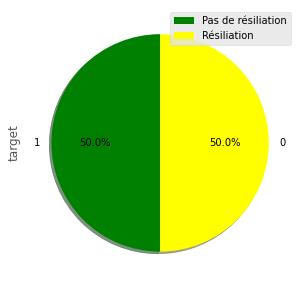

In [296]:
# on définit deux variables qui correspondent au nombre de personnes qui ont résilié et vice-versa
count_class_0, count_class_1 = df.target.value_counts()
#on isole dans le dataset les personnes qui ont résilié et celles qui n'ont pas résilié
df_class_0 = df[df['target'] == 0]
df_class_1 = df[df['target'] == 1]
#on rééquilibre le dataset avec la fonction sample
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
#on créé un dataset équilibré
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())
print("Il y a {} observations et {} features dans ce dataset. \n".format(df_test_over.shape[0],df_test_over.shape[1]))
df_test_over.target.value_counts().plot(kind='pie', figsize=(5, 5), colors=colors,autopct='%1.1f%%', shadow=True, startangle=90) 
plt.legend(labels,loc='best')
plt.show()

In [297]:
#on fait un split de notre dataset équilibré. le test_size est de 0.2 car le jeu de donnée n'est pas très grand.
X_train, X_test, y_train, y_test = train_test_split(
    df_test_over.drop('target', axis=1), df_test_over['target'],
    test_size=0.2, random_state=20)

le choix de l'arbre de décision a été motivé par sa performance quant à la résolution d'un problème de classification binaire sur un petit jeu de données. C'est l'algorithme qui donne les meilleurs résultats. 

Pour cet exercice j'ai également essayé un classifieur bayésien, une régression logistique et un SVM. Les résultats du SVM et de l'arbre de décision sont assez proche, mais le F1-Score de la classe 0 pour l'arbre de décision est légèrement supérieure. Sur chaque modèle essayé, j'ai fait varier les paramètres afin d'observer si les résultats s'amélioraient.

In [298]:
# on utilise l'arbre de décision avec l'entropie
clf_tree = tree.DecisionTreeClassifier(criterion = 'entropy',splitter = 'best')
clf_tree.fit(X_train, y_train)
prediction = clf_tree.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       165
           1       0.92      0.99      0.96       167

    accuracy                           0.95       332
   macro avg       0.96      0.95      0.95       332
weighted avg       0.96      0.95      0.95       332



In [299]:
#ici on charge le fichier de scoring afin de faire notre prédiction
uploaded = files.upload()

Saving scoring_SC_GGP_AXA_FR.csv to scoring_SC_GGP_AXA_FR (2).csv


In [300]:
#on importe le fichier csv sous format pandas
new_df = pd.read_csv('/content/scoring_SC_GGP_AXA_FR.csv',sep=',')
new_df.head(10)

,index,age,departement,categorie_socio_professionnelle,type_de_bien,statut,surface,montant_assure,debut_contrat,nb_sinistres_depuis_ouverture,ouverture_dernier_sinistre,cloture_dernier_sinistre,cotisation_n-1,cotisation_n
0,1000,19.0,81,Employés,Maison,Propriétaire,158.35,45419.0,2005-10-13 00:00:00,3.0,2007-04-12 14:57:38,2007-07-21 14:57:38,376.12,387.09
1,1001,49.0,70,Employés,Maison,Propriétaire,125.06,13374.0,2014-04-10 00:00:00,1.0,2017-10-31 07:46:20,2017-11-10 07:46:20,314.26,314.49
2,1002,30.0,55,"Artisans, commerçants, chefs d'entreprise",Appartement,Locataire,87.29,17763.0,1999-11-09 00:00:00,2.0,2002-09-09 08:58:42,2002-09-10 08:58:42,204.33,208.21
3,1003,62.0,61,Agriculteurs exploitants,Appartement,Locataire,69.58,24241.0,2020-09-24 00:00:00,0.0,NaN,NaN,208.14,210.10
4,1004,21.0,75,Agriculteurs exploitants,Appartement,Locataire,76.56,19501.0,1999-08-21 00:00:00,2.0,2001-06-28 15:59:21,2001-06-29 15:59:21,201.64,210.30
5,1005,53.0,78,Employés,Appartement,Locataire,43.54,34634.0,2000-10-15 00:00:00,1.0,2002-03-24 22:31:56,2002-08-17 22:31:56,216.32,223.41
6,1006,35.0,93,Employés,Appartement,Locataire,78.87,18030.0,2018-01-10 00:00:00,1.0,2019-03-24 23:09:17,2019-06-03 23:09:17,205.07,208.38
7,1007,15.0,75,Employés,Appartement,Propriétaire,60.66,15889.0,2014-09-22 00:00:00,1.0,2019-05-13 07:14:47,2019-07-14 07:14:47,247.31,247.67
8,1008,31.0,55,Agriculteurs exploitants,Appartement,Propriétaire,75.71,8595.0,2012-05-11 00:00:00,2.0,2015-11-24 06:43:33,2016-02-22 06:43:33,220.18,227.60
9,1009,16.0,51,Employés,Maison,Locataire,149.34,26247.0,2013-02-07 00:00:00,1.0,2015-08-08 10:46:59,2015-08-14 10:46:59,406.03,421.68


In [301]:
#on applique le préprocessing des données catégoriques à ce nouveau dataset
categorize(new_df)
#on applique le préprocesing des dates à ce nouveau dataset
split_convert_date(new_df,"ouverture_dernier_sinistre")
split_convert_date(new_df,"debut_contrat")
split_convert_date(new_df,"cloture_dernier_sinistre")

,index,age,departement,categorie_socio_professionnelle,type_de_bien,statut,surface,montant_assure,nb_sinistres_depuis_ouverture,cotisation_n-1,cotisation_n,année_ouverture_dernier_sinistre,mois_ouverture_dernier_sinistre,jour_ouverture_dernier_sinistre,heure_ouverture_dernier_sinistre,année_debut_contrat,mois_debut_contrat,jour_debut_contrat,heure_debut_contrat,année_cloture_dernier_sinistre,mois_cloture_dernier_sinistre,jour_cloture_dernier_sinistre,heure_cloture_dernier_sinistre
0,1000,19.0,74,3,1,2,158.35,45419.0,3.0,376.12,387.09,2007.0,4.0,12.0,14.0,2005,10,13,0,2007.0,7.0,21.0,14.0
1,1001,49.0,63,3,1,2,125.06,13374.0,1.0,314.26,314.49,2017.0,10.0,31.0,7.0,2014,4,10,0,2017.0,11.0,10.0,7.0
2,1002,30.0,50,1,0,0,87.29,17763.0,2.0,204.33,208.21,2002.0,9.0,9.0,8.0,1999,11,9,0,2002.0,9.0,10.0,8.0
3,1003,62.0,55,0,0,0,69.58,24241.0,0.0,208.14,210.10,-1.0,-1.0,-1.0,-1.0,2020,9,24,0,-1.0,-1.0,-1.0,-1.0
4,1004,21.0,68,0,0,0,76.56,19501.0,2.0,201.64,210.30,2001.0,6.0,28.0,15.0,1999,8,21,0,2001.0,6.0,29.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1295,46.0,67,2,1,2,141.56,26849.0,0.0,386.36,395.15,-1.0,-1.0,-1.0,-1.0,1999,6,18,0,-1.0,-1.0,-1.0,-1.0
296,1296,45.0,70,0,1,2,76.31,15048.0,1.0,382.09,384.90,2016.0,6.0,25.0,1.0,2014,11,9,0,2016.0,6.0,26.0,1.0
297,1297,59.0,14,3,1,2,115.41,21722.0,0.0,415.03,422.36,-1.0,-1.0,-1.0,-1.0,1996,8,20,0,-1.0,-1.0,-1.0,-1.0
298,1298,44.0,60,5,0,0,84.41,11456.0,0.0,221.25,244.45,-1.0,-1.0,-1.0,-1.0,2007,2,14,0,-1.0,-1.0,-1.0,-1.0


In [302]:
#on reprend le modèle qu'on a utilisé et on réalise une prédiction
last_pred = clf_tree.predict(new_df)
#la prédiction est stockée dans la variable last_pred et est ajoutée à notre dataset
new_df['last_pred'] = last_pred
new_df.head()

,index,age,departement,categorie_socio_professionnelle,type_de_bien,statut,surface,montant_assure,nb_sinistres_depuis_ouverture,cotisation_n-1,cotisation_n,année_ouverture_dernier_sinistre,mois_ouverture_dernier_sinistre,jour_ouverture_dernier_sinistre,heure_ouverture_dernier_sinistre,année_debut_contrat,mois_debut_contrat,jour_debut_contrat,heure_debut_contrat,année_cloture_dernier_sinistre,mois_cloture_dernier_sinistre,jour_cloture_dernier_sinistre,heure_cloture_dernier_sinistre,last_pred
0,1000,19.0,74,3,1,2,158.35,45419.0,3.0,376.12,387.09,2007.0,4.0,12.0,14.0,2005,10,13,0,2007.0,7.0,21.0,14.0,0
1,1001,49.0,63,3,1,2,125.06,13374.0,1.0,314.26,314.49,2017.0,10.0,31.0,7.0,2014,4,10,0,2017.0,11.0,10.0,7.0,0
2,1002,30.0,50,1,0,0,87.29,17763.0,2.0,204.33,208.21,2002.0,9.0,9.0,8.0,1999,11,9,0,2002.0,9.0,10.0,8.0,0
3,1003,62.0,55,0,0,0,69.58,24241.0,0.0,208.14,210.10,-1.0,-1.0,-1.0,-1.0,2020,9,24,0,-1.0,-1.0,-1.0,-1.0,0
4,1004,21.0,68,0,0,0,76.56,19501.0,2.0,201.64,210.30,2001.0,6.0,28.0,15.0,1999,8,21,0,2001.0,6.0,29.0,15.0,0


Il y a 300 observations et 24 features dans ce dataset. 

0    248
1     52
Name: last_pred, dtype: int64


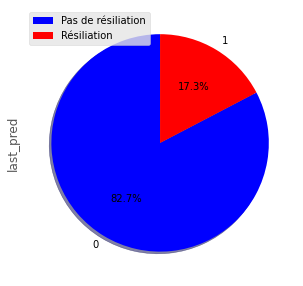

In [303]:
print("Il y a {} observations et {} features dans ce dataset. \n".format(new_df.shape[0],new_df.shape[1]))
colors = ['blue', 'red']
print(new_df.last_pred.value_counts())
new_df.last_pred.value_counts().plot(kind='pie', figsize=(5, 5), colors=colors,autopct='%1.1f%%', shadow=True, startangle=90) 
plt.legend(labels,loc='best')
plt.show()

In [305]:
#on exporte notre dataset sous format csv
new_df.to_csv('results_Axa.csv') 
files.download('results_Axa.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>